<a href="https://colab.research.google.com/github/bipinthecoder/litter_detection_model/blob/main/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-CNN implementation

R-CNN is one of the first algorithm for object detection (clasification and localisation) and was proposed by Girshick, Donahue, Darrell and Malik, CVPR 2014
(https://ieeexplore.ieee.org/document/6909475). Typically R stands for region, where region
 proposals are made within the image which are then fed to a CNN classifier.
Therefore, it can perform simultaneous classification and localisation. This practical is
an implementation of the same using Keras. Acknowledgement: R. Thakur, J. Han.

![RCNN.png](attachment:RCNN.png)

## Overall algorithmic flow

Note: for simplification we don’t use step 5 (NMS - non maxima suppression) in this practical.

![RCNNsteps.png](attachment:RCNNsteps.png)

## Task 1: Download the dataset and annotations

An airplane dataset and its annotations are available to download. The annotations are in CSV
format with each row indicates the location details (x1,y1,x2,y2). The first row indicates how many
airplanes are there.

## Task 2: Read  images and annotations

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf


In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random
#import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
#Importing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Setting file paths in drive
path = '/content/drive/MyDrive/CourseWork/Deeplearning for Vision and NLP/litter_detection_model'

#raw images
raw_image_path = path + '/raw_images'
punalur_falkirk_raw_image_path = raw_image_path + '/Falkirk_Punalur/'
falkirk_raw_image_path = raw_image_path + '/Falkirk'

#annotated images
annotated_image_path = path + '/annotated_images'
punalur_falkirk_annotated_image_path = annotated_image_path + '/Falkirk_Punalur/'
falkirk_annotated_image_path = annotated_image_path + '/Falkirk'


In [5]:
# path = "archive\Images\Images"
# annot="archive\Airplanes_Annotations\Airplanes_Annotations"

In [5]:
punalur_falkirk_raw_images = [image for image in os.listdir(raw_image_path+'/Falkirk_Punalur/')]

In [6]:
def resize_image(img, shape):
  resized_img = cv2.resize(img, shape)
  return resized_img

(1848, 4000, 3)
(224, 224, 3)


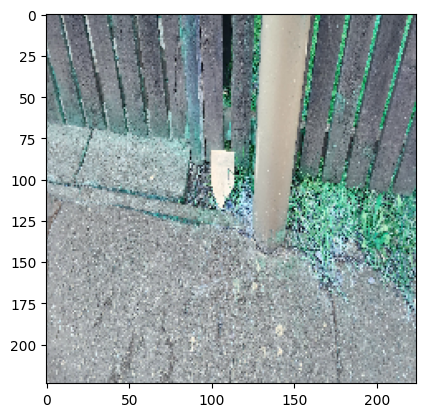

In [7]:
test_img = punalur_falkirk_raw_images[20]

test_img = cv2.imread(punalur_falkirk_raw_image_path + test_img)
print(test_img.shape)

resized_img = resize_image(test_img, (224, 224))
print(resized_img.shape)
# print(resized_img)
test_img = resized_img.copy()
test_img = ((test_img - test_img.min()) / (test_img.max() - test_img.min())) * 255
test_img = test_img.astype(np.uint8)
plt.imshow(test_img)


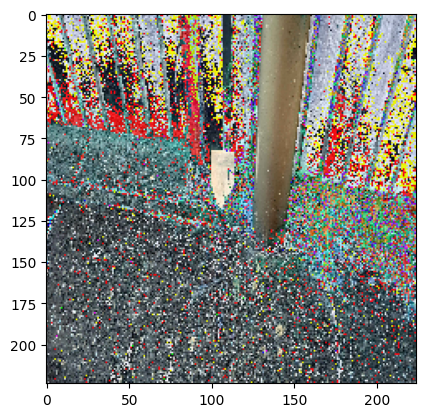

In [9]:
c = 2
gamma = 1.0
img_gamma = (c*(np.power(test_img/255,gamma))*255).astype(np.uint8)
plt.imshow(img_gamma)

In [8]:
def perform_image_preprocessing(image):

  image = ((image - image.min()) / (image.max() - image.min())) * 255
  image = image.astype(np.uint8)
  c = 2
  gamma = 1.0
  img_gamma = (c*(np.power(image/255,gamma))*255).astype(np.uint8)
  # plt.imshow(img_gamma)
  return img_gamma


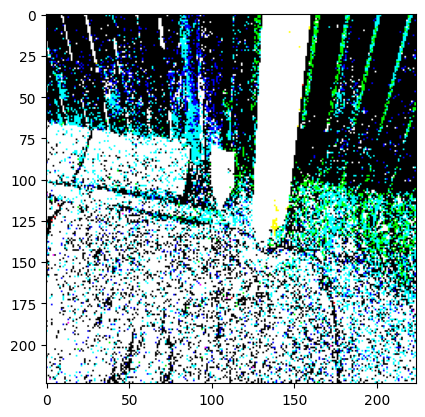

In [10]:
L = 256
img_mean = np.mean(test_img)
img_threshold = test_img.copy() # Create a copy of the image to manipulate
img_threshold[img_threshold <= img_mean] = 0
img_threshold[img_threshold >= img_mean] = L-1

plt.imshow(img_threshold)

In [9]:
def get_rectangle_coordinates_from_image(image, x_center, y_center, height, width):
  H, W, _ = image.shape
  # print(f'H is {H} and W is {W}')
  x1 = int((x_center - width / 2) * W)
  y1 = int((y_center - height / 2) * H)
  x2 = int((x_center + width / 2) * W)
  y2 = int((y_center + 3 * height / 2) * H)
  return x1, y1, x2, y2

In [10]:
txt_files = [f for f in os.listdir(punalur_falkirk_annotated_image_path) if f.lower().endswith('.txt')]
try:
  txt_files.remove('classes.txt')
except ValueError:
  print(f'classes.txt not present')

# Reading the content of each .txt file

annotated_punalur_falkirk_files = []
for txt_file in txt_files:
    # print(txt_file)
    file_path = os.path.join(punalur_falkirk_annotated_image_path, txt_file)
    with open(file_path, 'r') as f:
        cols = ['label_class', 'x_center', 'y_center', 'width', 'height']
        content = pd.read_csv(f, sep=' ', names = cols)
        annotated_punalur_falkirk_files.append({txt_file:content})

print(len(annotated_punalur_falkirk_files))

classes.txt not present
229


In [11]:
def perform_region_proposal(image):
  #Implementing Selective Search
  # Perform region proposals using Selective Search
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast() 
  regions = ss.process()
  return regions

In [ ]:
# def calculate_iou(box1, box2):
#     # Calculate intersection area
#     x1 = max(box1[0], box2[0])
#     y1 = max(box1[1], box2[1])
#     x2 = min(box1[2], box2[2])
#     y2 = min(box1[3], box2[3])
#     intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

#     # Calculate union area
#     box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
#     box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
#     union_area = box1_area + box2_area - intersection_area

#     # Calculate IoU
#     iou = intersection_area / union_area
#     return iou

In [ ]:
# def calculate_iou(bb1, bb2):
#     assert bb1['x1'] < bb1['x2']
#     assert bb1['y1'] < bb1['y2']
#     assert bb2['x1'] < bb2['x2']
#     assert bb2['y1'] < bb2['y2']

#     x_left = max(bb1['x1'], bb2['x1'])
#     y_top = max(bb1['y1'], bb2['y1'])
#     x_right = min(bb1['x2'], bb2['x2'])
#     y_bottom = min(bb1['y2'], bb2['y2'])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0
#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
#     bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
#     iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
#     assert iou >= 0.0
#     assert iou <= 1.0
#     return iou


In [12]:
def calculate_iou(box1, box2):
  
    # Calculate intersection area
    x1 = max(box1['x1'], box2['x1'])
    y1 = max(box1['y1'], box2['y1'])
    x2 = min(box1['x2'], box2['x2'])
    y2 = min(box1['y2'], box2['y2'])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1['x2'] - box1['x1'] + 1) * (box1['y2'] - box1['y1'] + 1)
    box2_area = (box2['x2'] - box2['x1'] + 1) * (box2['y2'] - box2['y1'] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

20230304_133137.txt
check
96 83 107 124
(224, 224, 3)


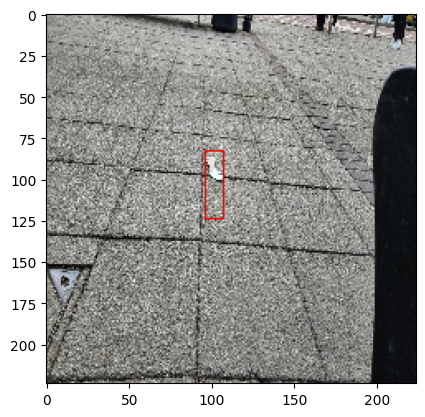

20230304_142514.txt
check
82 95 106 123
check
144 71 154 78
check
198 80 212 87
check
74 137 89 150
check
3 198 19 216
(224, 224, 3)


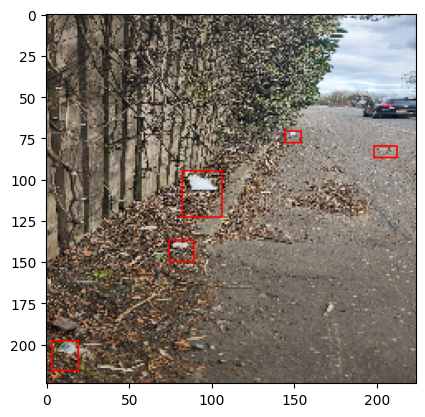

20230304_142518.txt
check
88 77 118 119
(224, 224, 3)


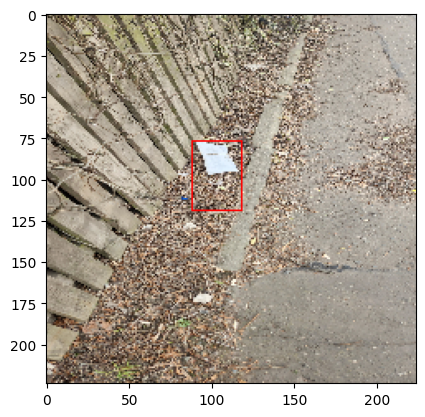

20230304_142525.txt
check
92 36 120 54
check
90 128 134 175
(224, 224, 3)


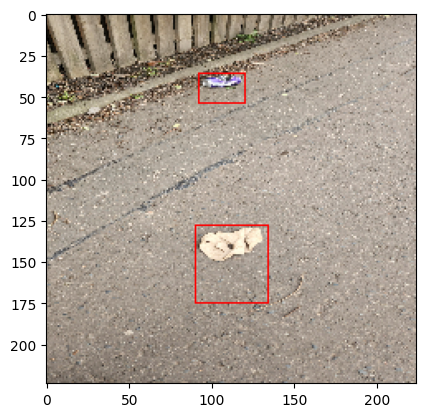

20230304_142535.txt
check
90 86 154 101
check
120 94 140 105
check
129 83 137 91
(224, 224, 3)


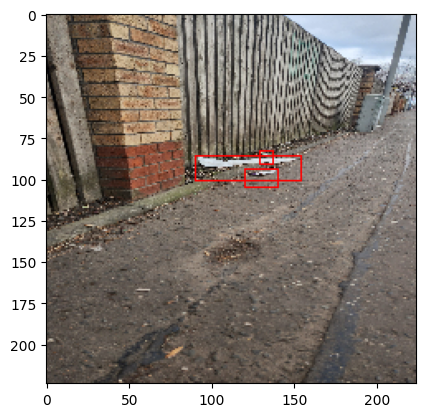

20230304_142550.txt
check
99 101 121 121
(224, 224, 3)


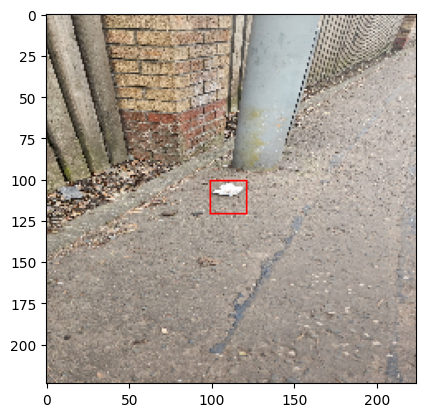

In [13]:
# for count, annotated_file in enumerate(annotated_punalur_falkirk_files):
#   #Extracting file name to fetch the corresponding raw image
#   file_name = list(annotated_file.keys())[0]
#   print(file_name)

#   # Reading the corresponding raw image
#   image_path = os.path.join(punalur_falkirk_raw_image_path, file_name.replace(".txt", ".jpg"))
#   base_image = cv2.imread(image_path)
  
#   if base_image is None:
#     continue
#   base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
#   copy_image = base_image.copy()
#   copy_image = resize_image(copy_image, (224, 224))


#   box_values_from_annot_file = []

#   for entry in annotated_file:

#       #Iterating through each lines of the annotated file(ie, different object labels)
#       df = annotated_file[entry]
#       for index, row in df.iterrows():
#         class_label = row['label_class']
#         x_center = row['x_center']
#         y_center = row['y_center']
#         height = row['height']
#         width = row['width']
#         x1, y1, x2, y2 = get_rectangle_coordinates_from_image(copy_image, x_center, y_center, height, width)
#         print('check')
#         print(x1,y1,x2,y2)
#         box_obj = {"x1":x1, "y1":y1, "x2":x2, "y2":y2}
#         box_values_from_annot_file.append(box_obj)
#         cv2.rectangle(copy_image,(x1,y1),(x2,y2),(255,0,0), 1)
 
#   print(copy_image.shape)
#   plt.imshow(copy_image)
#   plt.show()
#   if count == 5:
#     break
  

## Task 3: Selective search

Use OpenCV function for selective search to create regions for potential foreground objects and
visualise them.

In [ ]:
# cv2.setUseOptimized(True);
# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
# im = cv2.imread(os.path.join(path,filename))
# ss.setBaseImage(im)
# ss.switchToSelectiveSearchFast()
# rects = ss.process()
# imOut = im.copy()
# for i, rect in (enumerate(rects)):
#     x, y, w, h = rect
#     cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.imshow(imOut)

## Task 4: Intersection over Union (IoU)

Intersection over Union (IoU) are improtant to understand/calculate the overlap between the detected region and the ground truth (actual region).

![IoU.png](attachment:IoU.png)

In [ ]:
# def get_iou(boxA, boxB):
# 	# determine the (x, y)-coordinates of the intersection rectangle
# 	xA = max(boxA[0], boxB[0])
# 	yA = max(boxA[1], boxB[1])
# 	xB = min(boxA[2], boxB[2])
# 	yB = min(boxA[3], boxB[3])
# 	# compute the area of intersection rectangle
# 	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
# 	# compute the area of both the prediction and ground-truth
# 	# rectangles
# 	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
# 	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
# 	# compute the intersection over union by taking the intersection
# 	# area and dividing it by the sum of prediction + ground-truth
# 	# areas - the intersection area
# 	iou = interArea / float(boxAArea + boxBArea - interArea)
# 	# return the intersection over union value
# 	return iou

## Task 5: Preprocessing and creation of dataset

In this practical, we creat two classes: forground objects (airplane) and background (everything
else) with labels 1 and 0, respectively. This is done through selective search to create the regions for
the proposals. Each of these regions are then treated as seprate image to pass on to the classifier.
One single image can have multiple regions and top 2000 regions are considered as proposed in
the original paper. Regions with more than 0.7 IoUs are labeled as the foreground (or airplane)
objects. We loop through the entire training set available.

In [13]:
train_images=[]
train_labels=[]

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
# def get_rectangle(csv_annot):
#     df = pd.read_csv(csv_annot)
#     boxes=[]
#     for row in df.iterrows():
#         x1 = int(row[1][0].split(" ")[0])
#         y1 = int(row[1][0].split(" ")[1])
#         x2 = int(row[1][0].split(" ")[2])
#         y2 = int(row[1][0].split(" ")[3])
#         box={"x1":x1,"x2":x2,"y1":y1,"y2":y2}
#         boxes.append(box)
#     return boxes

In [14]:
def rectang_from_image(image, x, y, w, h):
    timage = image[y : y + h, x : x + w]
    resized = cv2.resize(timage,
                     (224,224),
                     interpolation = cv2.INTER_AREA)
    return resized

In [ ]:
# img_name=random.choice(images)
# img = cv2.imread(os.path.join(path,img_name))
# plt.imshow(img)
# csv_file = os.path.join(annot,str(img_name).split(".")[0]+".csv")
# boxes=get_rectangle(csv_file)
# for box in boxes:
#     cv2.rectangle(img,(box['x1'],box['y1']),(box['x2'],box['y2']),(255,0,0), 2)
# plt.figure()
# plt.imshow(img)
  
# cv2.setUseOptimized(True);
# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
# ss.setBaseImage(img)
# ss.switchToSelectiveSearchFast()
# rects = ss.process()
# imOut = img.copy()
# for i, rect in (enumerate(rects)):
#     x, y, w, h = rect
#     cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# # plt.figure()
# plt.imshow(imOut)

In [15]:
image_list = os.listdir(punalur_falkirk_raw_image_path)


In [33]:
max_proposal = 2000
max_samples = 100
IOU_treshold_plane = 0.7
IOU_treshold_background = 0.3

# path = "archive\Images\Images"
# annot="archive\Airplanes_Annotations\Airplanes_Annotations"

# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

train_images=[]
train_labels=[]
# images=os.listdir(path)

In [17]:
def get_annotation_coord_from_txt(annotated_file, image):
  box_values_from_annot_file = []

  for index, row in annotated_file.iterrows():
    class_label = row['label_class']
    x_center = row['x_center']
    y_center = row['y_center']
    height = row['height']
    width = row['width']
    x1, y1, x2, y2 = get_rectangle_coordinates_from_image(image, x_center, y_center, height, width)
    box_obj = {"x1":x1, "y1":y1, "x2":x2, "y2":y2}
    box_values_from_annot_file.append(box_obj)
  return box_values_from_annot_file

In [18]:
def find_and_get_box_values_from_txt(file_name, image):
  annot_file = pd.DataFrame()
  for item in annotated_punalur_falkirk_files:
    #checking if file_name is in the dictionary key
    if file_name in item:
      annot_file = item[file_name]
      break
  
  if annot_file.empty:
    print(f'DataFrame is empty! and the file is {file_name}')
    return []
  else:
    box_values = get_annotation_coord_from_txt(annot_file, image)
    return box_values
    

In [ ]:
# selective_search_results = []

**Creating Dataset for Training**

In [19]:
train_images=[]
train_labels=[]
for count, image_file in enumerate(tqdm(image_list, "Processing Images")):
  try:
    box_values_from_annot_file = []

    image_to_process_path = os.path.join(punalur_falkirk_raw_image_path,image_file)
    image_ = cv2.imread(image_to_process_path)
    image_to_process = image_.copy()
    image_to_process = perform_image_preprocessing(image_to_process)

    try_image = image_to_process.copy()
    try_image = resize_image(try_image, (224, 224))

    #Getting corresponding Annotation file
    annot_file_name = image_file.replace(".jpg", ".txt")
    # print(annot_file_name)
    coordinates_from_annot_file = find_and_get_box_values_from_txt(annot_file_name, try_image)
    if len(coordinates_from_annot_file) == 0:
      print("File is not present")
      continue
    box_values_from_annot_file.extend(coordinates_from_annot_file)

    selective_search_results = perform_region_proposal(try_image)

    # print(f'Selective Search results are : {selective_search_results}')
    counter = flag = falsecounter = fflag = bflag = 0
    for e, result in enumerate(selective_search_results):
        if e < max_proposal and flag == 0:
            for a_box in box_values_from_annot_file:
                x, y, w, h = result
                
                # cv2.rectangle(try_image, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA )
                
                iou = calculate_iou(a_box,{"x1" : x,"x2" : x+w,"y1" : y,"y2" : y+h})
                if counter < max_samples:
                    if iou > IOU_treshold_plane:
                        train_images.append(rectang_from_image(try_image, x, y, w, h))
                        train_labels.append(1)
                        counter += 1
                else:
                    fflag = 1
                if falsecounter < max_samples:
                    if iou < IOU_treshold_background:
                        train_images.append(rectang_from_image(try_image, x, y, w, h))
                        train_labels.append(0)
                        falsecounter += 1
                else:
                    bflag = 1
            if fflag == 1 and bflag==1:
                flag=1
    # plt.imshow(try_image)
    # break
  except:
    print(f'Exception for the file {image_file}')

Processing Images:   0%|          | 0/234 [00:00<?, ?it/s]

DataFrame is empty! and the file is IMG_20230321_184653.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_184911.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_184650.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_184528.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_184854.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_183310.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_183020.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_183806.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_183944.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_183723.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_184024.txt
File is not present
DataFrame is empty! and the file is IMG_20230321_183010.txt
File is not present
DataFrame is empty! and the file is IMG_

In [20]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

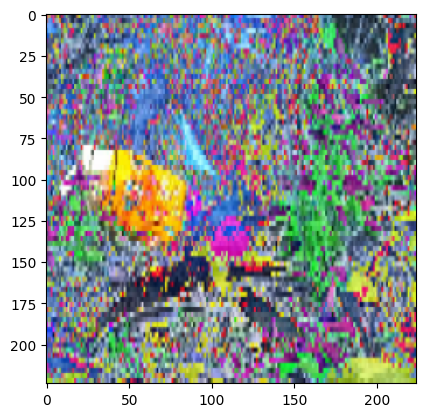

In [24]:
plt.imshow(X_new[-1])

In [21]:
print(len(y_new))
print(y_new)

24720
[0 0 0 ... 1 1 1]


## Task 6: Use of trained model for classification

As a main part of this algorithm is to classify, we use a standard pre-trained classifier VGG16 and
fine tune it. The VGG16 classifier is already train on ImageNet (https://www.image-net.org/) on
1000 classes. VGG16 is already available through Keras framework and can readily be used. This
implementation also passed a few parameters that are optimal / required in this case.

Please note that, a different pre-trained classifier can also be used.
As we just need two classes for this lab, we freeze the first 15 layers of the model followed by taking
out the second last layer of the model and then adding a 2 unit softmax dense layers for prediction
(2 classes: foreground or background).

In [20]:
vggmodel = VGG16(weights='imagenet', include_top=True)

for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
    
X= vggmodel.layers[-2].output
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(vggmodel.input,predictions)
opt = Adam(lr=0.0001)
model_final.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()

553467096/553467096 [==============================] - 3s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Task 7: Preparation of training and testing data

Split the dataset in train and test / validation set. 

In [21]:
X_new = np.array(train_images)
# X_new = preprocess_input(X_new)  # preprocess the input images
y_new = np.array(train_labels)

X_train, X_test , y_train, y_test = train_test_split(X_new,y_new,test_size=0.10)

In [22]:
print(X_train.shape)

(22248, 224, 224, 3)


## Task 8: Data augmentation

It is a common practice in the deep learning to augment the data to increase the size. In this case
augmentations were doen through horizontal flip, vertical flip and rotations.

In [23]:
trdata    = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=0)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata    = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=0)
testdata  = tsdata.flow(x=X_test, y=y_test)

## Task 9: Training the R-CNN architecture

Now start training of the model using the fit_generation().

In [24]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')

hist = model_final.fit_generator(generator= traindata,
                                 steps_per_epoch= 10,
                                 epochs= 100, 
                                 validation_data= testdata,
                                 validation_steps=2,
                                 callbacks=[checkpoint,early])

Epoch 1/100


<ipython-input-24-ff9db2fb6b8c>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata,


 9/10 [==========================>...] - ETA: 0s - loss: 100.6587 - accuracy: 0.6076
Epoch 1: val_loss improved from inf to 33.65099, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 20s 450ms/step - loss: 91.1553 - accuracy: 0.5719 - val_loss: 33.6510 - val_accuracy: 0.7812
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 16.6708 - accuracy: 0.7917
Epoch 2: val_loss improved from 33.65099 to 1.31635, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 5s 584ms/step - loss: 15.1391 - accuracy: 0.8000 - val_loss: 1.3164 - val_accuracy: 0.5000
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.2446 - accuracy: 0.6979
Epoch 3: val_loss did not improve from 1.31635
10/10 [==============================] - 0s 45ms/step - loss: 1.1814 - accuracy: 0.7031 - val_loss: 24.1965 - val_accuracy: 0.1406
Epoch 4/100
 9/10 [==========================>...] - ETA: 0s - loss: 3.8991 - accuracy: 0.6111
Epoch 4: va

## Task 10: Save final model

In [25]:
from IPython.display import HTML
def create_download_link(title = "Download model file", filename = './RNN_model.h5'):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)


model_final.save('./RNN_model.h5')
# create a link to download the model 
create_download_link(filename='./RNN_model.h5')

## Task 11: Visualisation of training

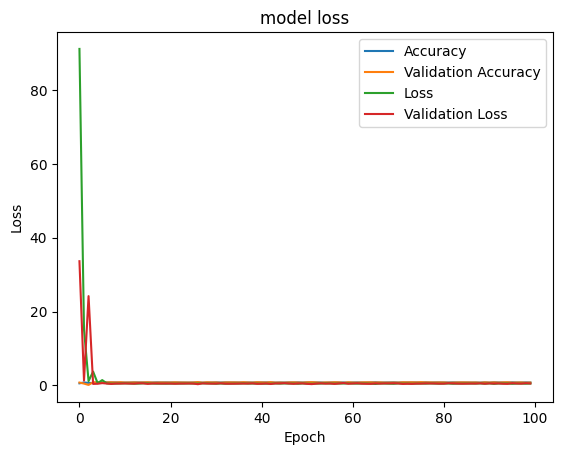

In [26]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss","Validation Loss"])
plt.show()

## Task 12: Predication

Now use the one of the images from the set to check the prediction.

1/1 [==============================] - 0s 30ms/step
[[0.24315207]]


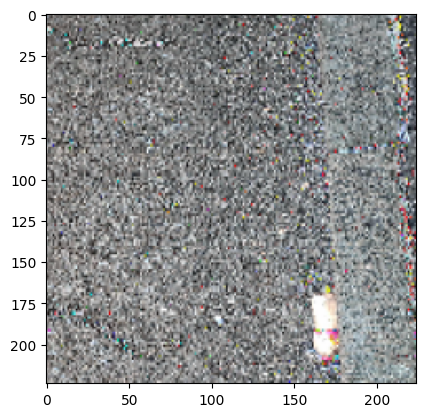

In [28]:
im = X_test[2]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
print(out)
# if out[0][0] > out[0][1]:
#     print("plane")
# else:
#     print("not plane")

In [ ]:
img = cv2.imread(raw_image_path + '/test/test3.jpg')
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
print(out)

## Task 13: Predication on unseen data

Now use images from the dataset which are not seen by the model during training. This steps may
take some time depending on how many images you are passing through.

1/1 [==============================] - 0s 38ms/step
[[0.24315207]]
1/1 [==============================] - 0s 31ms/step
[[0.24315207]]
1/1 [==============================] - 0s 30ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.24315207]]
1/1 [==============================] - 0s 30ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.24315207]]
1/1 [==============================] - 0s 30ms/step
[[0.24315207]]
1/1 [==============================] - 0s 34ms/step
[[0.24315207]]
1/1 [==============================] - 0s 30ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.24315207]]
1/1 [==============================] - 0s 27ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.24315207]]
1/1 [==============================] - 0s 29ms/step
[[0.243152

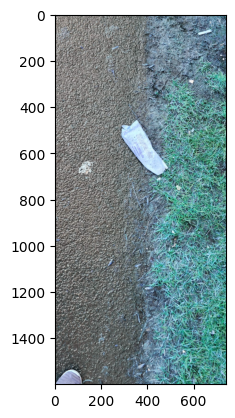

In [32]:
# img=random.choice(images)
img = cv2.imread(raw_image_path + '/test/test3.jpg')
# img = cv2.imread(os.path.join(path,img))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        print(out)
        if out[0][0] > 0.3:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score



# evaluating model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1) # convert probabilities to binary labels

precision = precision_score(np.argmax(y_test, axis=1), y_pred)
recall = recall_score(np.argmax(y_test, axis=1), y_pred)
f1 = f1_score(np.argmax(y_test, axis=1), y_pred)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
